In [57]:
import model as m
import explore as e
import wrangle as w
import pandas as pd
from importlib import reload
from sklearn.linear_model import LinearRegression
import warnings
warnings.simplefilter('ignore')

In [58]:
train,validate,test = w.tvt_split(w.wrangle_zillow())

In [59]:
reload(m)
m.select_baseline(train.log_error)

|                 |     SSE |       MSE |     RMSE |
|:----------------|--------:|----------:|---------:|
| Mean Baseline   | 1285.55 | 0.0296687 | 0.172246 |
| Median Baseline | 1289.55 | 0.0297612 | 0.172514 |
### Because mean outperformed median on all metrics,         we will use mean as our baseline

In [60]:
reload(m)
train_process_frame = train[['fireplace_count','latitude','longitude','tax_value','calc_sqft','bed_count','bath_count','log_error']].copy()
features = ['fireplace_count','bed_count','bath_count']
cluster_cols = ['tax_value','calc_sqft','latitude','longitude']
cluster_name = 'cluster_fuck'
target = 'log_error'
# log_error_min = train_process_frame.log_error.min()
# train_process_frame.log_error = train_process_frame.log_error - log_error_min
train_process_frame = train_process_frame.reset_index(drop=True)
clustered_scaled,scaler,clusterer = m.scale_and_cluster(train_process_frame,features=features,target=target,cluster_cols=cluster_cols,cluster_name=cluster_name,k=7)
regressors = m.generate_regressor(clustered_scaled,features=features,target=target,cluster_name=cluster_name,regressor=LinearRegression(normalize=True))
ypred = m.apply_to_clusters(clustered_scaled,features=features,target=target,cluster_name=cluster_name,regressors=regressors)
clustered_scaled.shape, train_process_frame.shape

((43330, 5), (43330, 8))

In [61]:
predictions_df = pd.DataFrame()
predictions_df['y_true'] = train.log_error
predictions_df['y_pred'] = 1.0
cluster_group = clustered_scaled.groupby('cluster_fuck')
for i,group in cluster_group:
    predictions_df.iloc[group.index,1] = regressors[i].predict(group)


ValueError: X has 5 features, but LinearRegression is expecting 3 features as input.

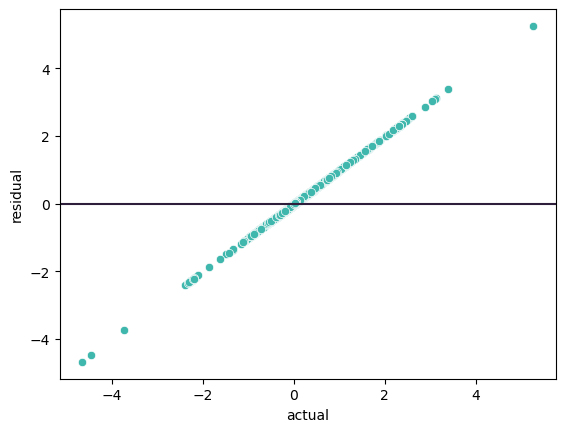

In [64]:
import evaluate as ev
ev.plot_residuals(ypred.y_true,ypred.y_pred)


In [ ]:
baselin
ev.plot_residuals()

In [62]:

ev.regression_errors(ypred.y_true,ypred.y_pred,'Regression Model')

,SSE,ESS,TSS,MSE,RMSE
Regression Model,1285.202538,1.191154,1286.393692,0.029661,0.172223


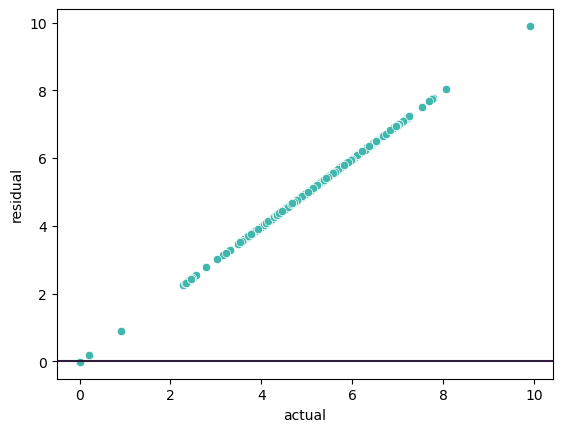

In [73]:
from sklearn.linear_model import TweedieRegressor


reload(m)
train_predictions,scaler,kmeans,regressor = m.process_model(df=train_process_frame,features=features,
    target=target,cluster_cols=cluster_cols,cluster_name='cluster_fuck',regressor=TweedieRegressor(power=0,alpha=1.0),k=7)
baseline_predictions = pd.Series([train.log_error.mean() for i in range(train.log_error.count())])
ev.plot_residuals(train_predictions.y_true,baseline_predictions)